Plots win rate and score margins throughout training.

In [1]:
from typing import Iterable, List, Mapping, Optional, Tuple

import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import utils
from statsmodels.stats.proportion import proportion_confint

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

In [2]:
def plot_training(
    df: pd.DataFrame,
    victim_name_to_plot_label: Mapping[str, str],
    highlighted_point_step: int,
    victim_change_steps: Iterable[int],
    adv_name: str,
    board_size: int = 19,
    ignored_adversaries: Optional[List] = None,
    legend_ncol: Optional[int] = None,
    wr_or_scorediff: Optional[str] = "wr",
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot win rate or score margin throughout training.

    Params:
        df: Data
        victim_name_to_plot_label: Key = victims to plot, value = label on plot legend
        highlighted_point_step: Point (specified by adversary training steps) to mark
          with a special marker on the plot
        victim_changes_steps: Training steps at which the victim changed
        adv_name: 'Pass' or 'Cyclic'
        plot_name: Filename of plot
        ignored_adversaries: Names of adversaries to ignore due to bad data
        legend_ncol: Override the number of legend_columns
        wr_or_scorediff: plot wr (winrate), scorediff (margin of victory),
          scorediff_advin (margin when adversary wins), or scorediff_advlose (margin when it loses)
    """
    assert wr_or_scorediff in [
        "wr",
        "scorediff",
        "scorediff_advwin",
        "scorediff_advlose",
    ]

    if ignored_adversaries is None:
        ignored_adversaries = []

    df = df.loc[df.board_size == board_size]
    for adv in ignored_adversaries:
        df = df.loc[df.adv_name != adv]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, axs = plt.subplots(1, 1)

    if wr_or_scorediff == "scorediff_advwin":
        df = df.loc[df.adv_minus_victim_score > 0]
    elif wr_or_scorediff == "scorediff_advlose":
        df = df.loc[df.adv_minus_victim_score < 0]

    if wr_or_scorediff == "wr":
        df["var_to_plot"] = df.adv_win * 100
        target_var_name = "adv_win"
    elif "scorediff" in wr_or_scorediff:
        df["var_to_plot"] = df.adv_minus_victim_score
        target_var_name = "adv_minus_victim_score"
        df = df[
            df.groupby(["adv_steps", "victim_name"])["adv_steps"]
            .transform("size")
            .gt(4)
        ]  # require at least 5 games for point to be plotted

    ALPHA = 0.05
    for i, (victim_name, victim_label) in enumerate(victim_name_to_plot_label.items()):
        victim_df = df[df.victim_name == victim_name]
        mean_df = victim_df.groupby("adv_steps").mean(True)
        ax = mean_df.var_to_plot.plot(label=victim_label)
        if wr_or_scorediff == "wr":
            conf_df = mean_df.apply(
                lambda x: proportion_confint(
                    len(
                        victim_df[
                            (victim_df.adv_steps == x.name)
                            & (victim_df[target_var_name])
                        ]
                    ),
                    len(victim_df[victim_df.adv_steps == int(x.name)]),
                    alpha=ALPHA,
                    # Generate Clopper-Pearson confidence intervals:
                    # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
                    method="beta",
                ),
                axis=1,
                result_type="expand",
            )
            conf_df = conf_df * 100

        else:
            std_df = victim_df.groupby("adv_steps").std(numeric_only=True)
            conf_df = mean_df.apply(
                lambda x: st.t.interval(
                    confidence=1 - ALPHA,
                    df=len(victim_df[victim_df.adv_steps == int(x.name)]) - 1,
                    loc=mean_df[mean_df.index == int(x.name)][target_var_name],
                    scale=std_df[std_df.index == int(x.name)][target_var_name]
                    / np.sqrt(len(victim_df[victim_df.adv_steps == int(x.name)])),
                    # Generate confidence intervals for mean based on t distribution:
                    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html
                ),
                axis=1,
                result_type="expand",
            )
            conf_df[0] = conf_df[0].apply(lambda x: x[0])
            conf_df[1] = conf_df[1].apply(lambda x: x[0])

        plt.fill_between(mean_df.index, conf_df[0], conf_df[1], alpha=0.3)

        if highlighted_point_step in mean_df.var_to_plot:
            # if there's a data point on which to mark the highest WR, mark it
            plt.plot(
                highlighted_point_step,
                mean_df.var_to_plot.loc[highlighted_point_step].item(),
                "D",
                color=colors[i],
                alpha=0.7,
            )
        elif (mean_df.index > highlighted_point_step).any() and (
            mean_df.index < highlighted_point_step
        ).any():
            # if there's no data point to mark directly but there's data points both before and after:
            # calculate the right place to mark through linear interpolation
            above_idx = mean_df[mean_df.index > highlighted_point_step].index.min()
            below_idx = mean_df[mean_df.index < highlighted_point_step].index.max()
            above_value = mean_df.loc[above_idx].var_to_plot.item()
            below_value = mean_df.loc[below_idx].var_to_plot.item()
            target_value = below_value + (highlighted_point_step - below_idx) * (
                (above_value - below_value) / (above_idx - below_idx)
            )
            plt.plot(
                highlighted_point_step,
                target_value,
                "D",
                color=colors[i],
                alpha=0.7,
            )

    max_step = df.adv_steps.max()
    for xc in victim_change_steps:
        if 0 < xc and xc < max_step:
            plt.axvline(x=xc, linestyle=":", linewidth=1, color=colors[3])

    if legend_ncol is None:
        legend_ncol = len(victim_name_to_plot_label)

    if wr_or_scorediff == "wr":
        plt.ylabel(rf"Adversary win rate \%")
        plt.legend(
            loc="lower center",
            bbox_to_anchor=(0.5, 1.0),
            ncols=legend_ncol,
            fancybox=True,
        )
        plt.xlabel(f"{adv_name}-adversary training steps")
    elif wr_or_scorediff == "scorediff":
        plt.ylabel("Score margin\n(adv. score - victim score)")
        plt.legend(
            loc="lower center",
            bbox_to_anchor=(0.5, 1.0),
            ncols=legend_ncol,
            fancybox=True,
        )
        plt.xlabel(f"{adv_name}-adversary training steps")
    elif wr_or_scorediff == "scorediff_advwin":
        plt.ylabel(r"Score margin (adv. wins)")
        plt.xlabel(f"{adv_name}-adversary training steps")
    elif wr_or_scorediff == "scorediff_advlose":
        plt.ylabel(r"Score margin (adv. losses)")
        plt.xlabel(f"{adv_name}-adversary training steps")

    plt.margins(x=0)
    _, x_max = plt.xlim()
    plt.xlim(left=-x_max * 0.02, right=x_max * 1.02)

    return fig, axs

In [3]:
training_df = utils.parse_sgfs(
    ["/nas/ucb/tony/go-attack/training/emcts1-curr/cp127-to-505-v1/selfplay"]
)
victim_change_steps = utils.get_victim_change_steps(training_df)
print("Victim change steps:", victim_change_steps)

df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-unhardened-paper-eval-221130/training-checkpoint-sweep"
    ]
)

print("All victims:", df.victim_name.unique())
victim_name_to_plot_label = {
    "cp127-v1": r"\texttt{cp127}$^\mathrm{1\,visit}$",
    "cp505-v1": r"\texttt{Latest}$^\mathrm{1\,visit}\;$",
}

best_performance_mark = 34090496 # where to put diamond that marks the best performing point in training

Victim change steps: [0, 0, 12560640, 16541696, 22263040, 25102336]
All victims: ['cp127-v1' 'cp505-v1' 'cp505h-v1']


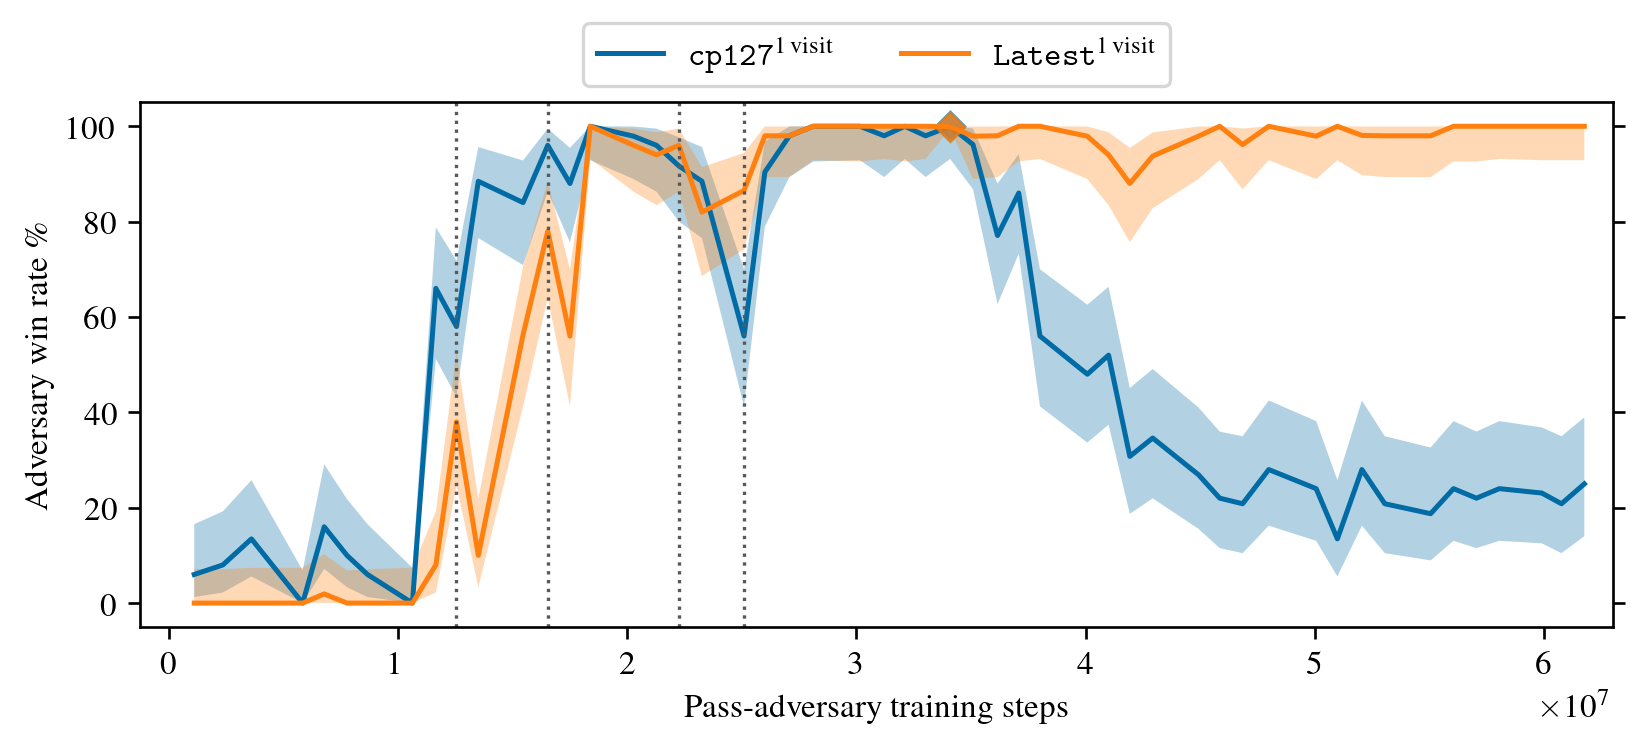

In [4]:
fig, _ = plot_training(
    df,
    victim_name_to_plot_label,
    best_performance_mark,
    victim_change_steps,
    adv_name="Pass",
)
fig.savefig("adv-training.pgf", backend="pgf")

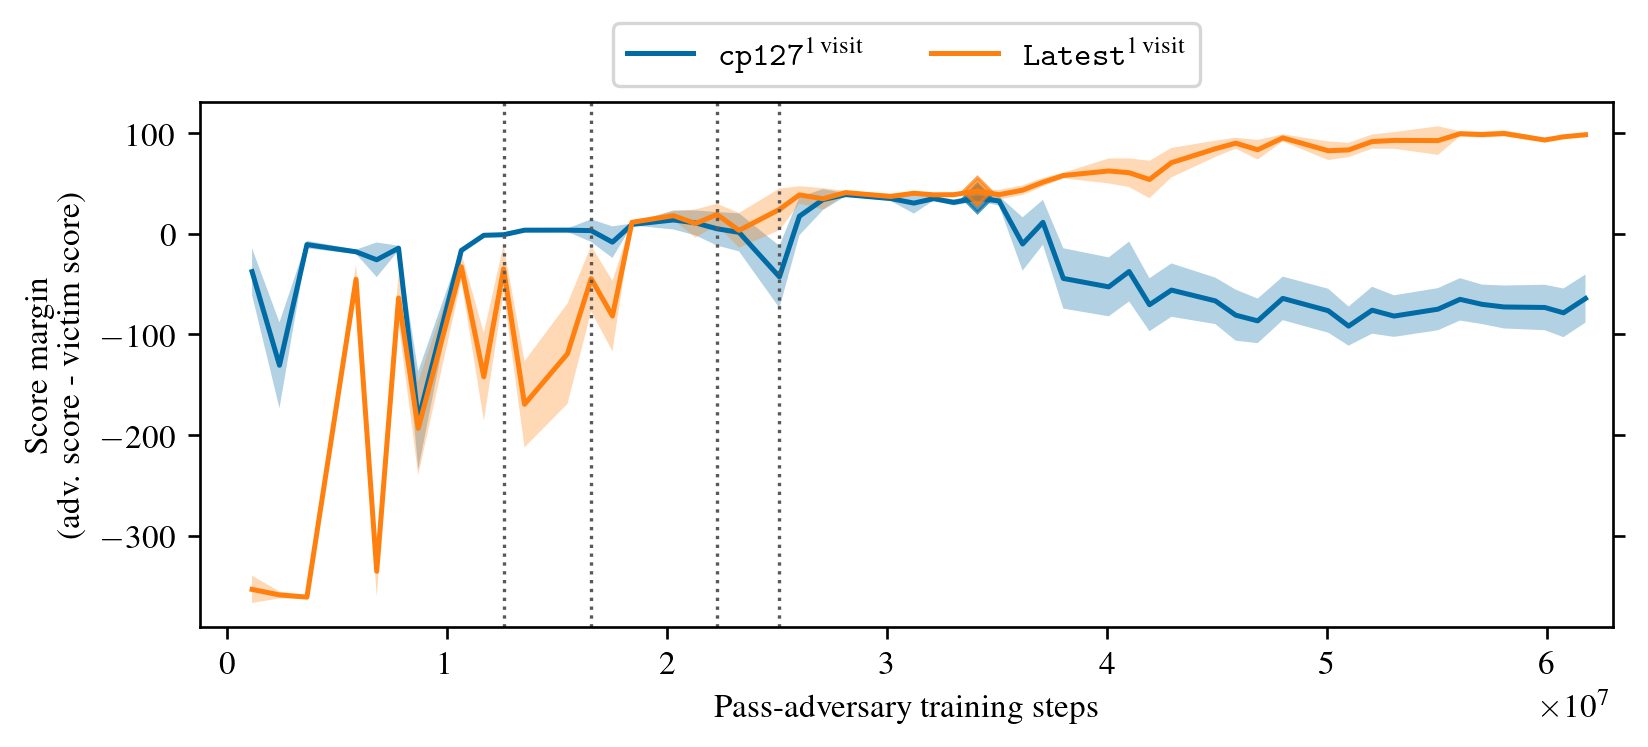

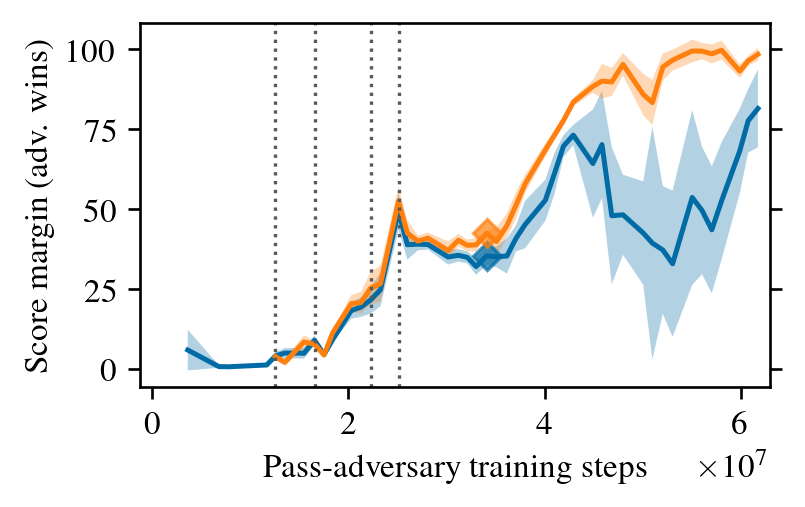

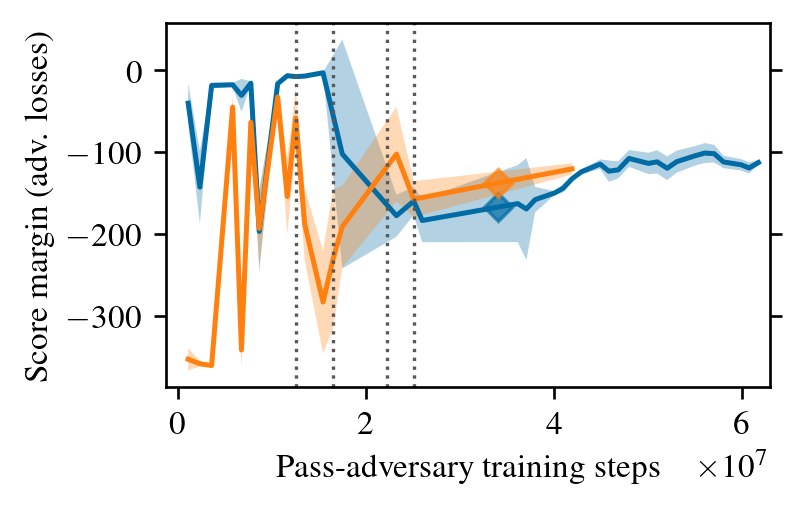

In [5]:
for intended_plot_type in ['scorediff','scorediff_advwin','scorediff_advlose']:
    if intended_plot_type in ['scorediff_advwin','scorediff_advlose']:
        tmp_plot_style = utils.get_style("2-col")
    else:
        tmp_plot_style = utils.get_style("1-col")
        
    with plt.style.context(tmp_plot_style):
        fig, _ = plot_training(
            df,
            victim_name_to_plot_label,
            best_performance_mark,
            victim_change_steps,
            wr_or_scorediff=intended_plot_type,
            adv_name="Pass",
        )
    
    fig.savefig(f"adv-training-{intended_plot_type}.pgf", backend="pgf")

In [6]:
training_df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/victimplay/ttseng-avoid-pass-alive-coldstart-39-20221025-175949/selfplay"
    ]
)
victim_change_steps = utils.get_victim_change_steps(training_df)
print("Victim change steps:", victim_change_steps)

df = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-hard-adv-checkpoint-sweep-s545mil-20230117"]
)
print("All victims:", df.victim_name.unique())
victim_name_to_plot_label = {
    "cp39h-v1": r"$\texttt{cp39}_\texttt{def}^\mathrm{1\,visit}$",
    "cp127h-v1": r"$\texttt{cp127}_\texttt{def}^\mathrm{1\,visit}$",
    "cp505h-v1": r"$\texttt{Latest}_\texttt{def}^\mathrm{1\,visit}$",
    "cp505h-v4096": r"$\texttt{Latest}_\texttt{def}^\mathrm{4096\,visits}\;$",
}

best_performance_mark = 545065216 # where to put diamond that marks the best performing point in training

Victim change steps: [0, 30365184, 34502144, 38566400, 87698176, 164908288, 194422784, 198203136, 205049600, 212038912, 218883584, 227013120, 227013120, 230932992, 417232384, 466991360, 486887168, 491808000, 495654912, 499575296, 503639552, 509699584, 516545024, 522673664, 529022720, 534938880, 539786240, 544065792]
All victims: ['cp505h-v4096' 'cp127h-v1' 'cp39h-v1' 'cp505h-v1' 'cp505-v1'
 'cp505-v4096']


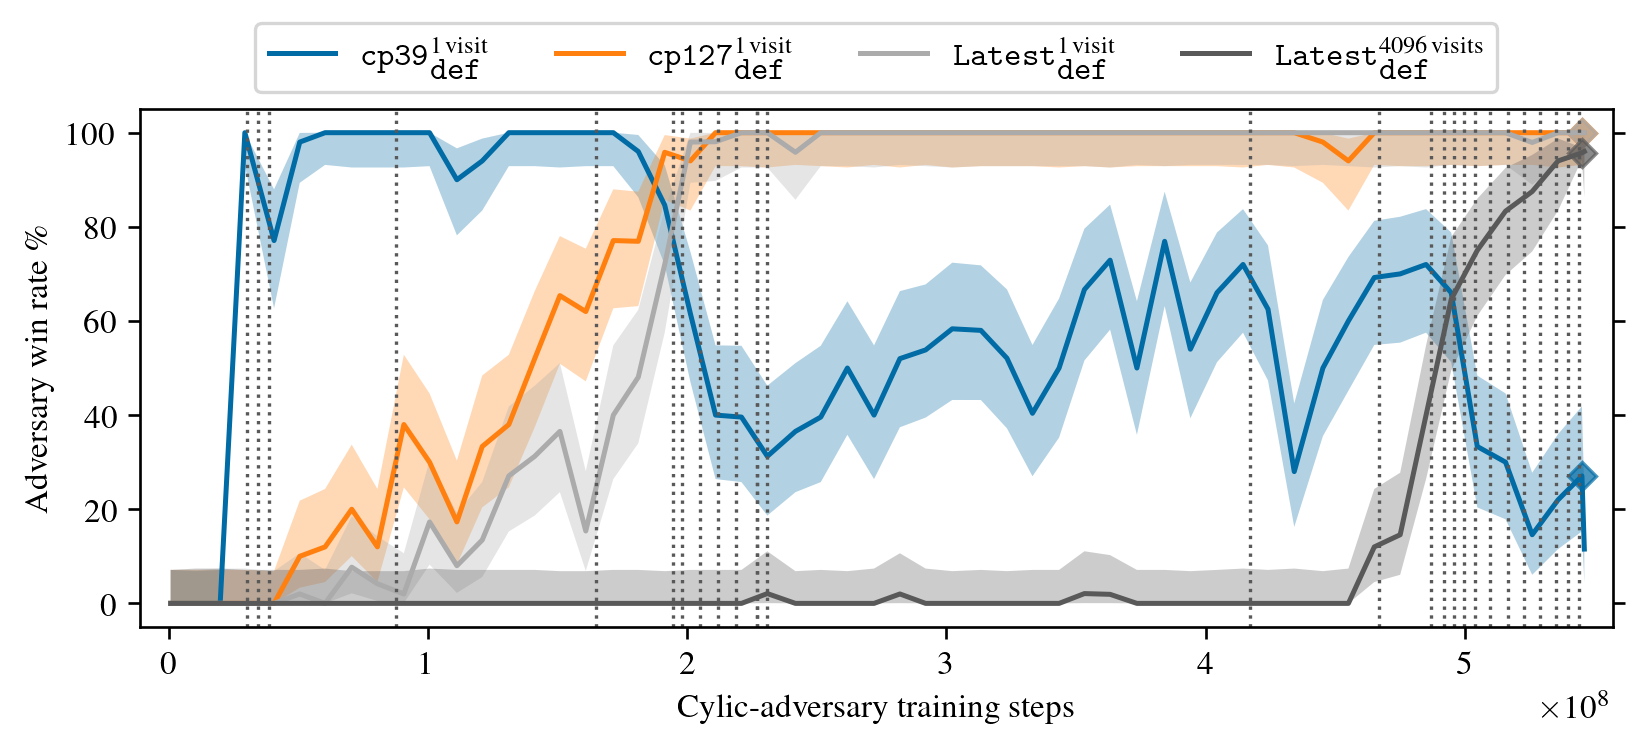

In [7]:
fig, _ = plot_training(
    df,
    victim_name_to_plot_label,
    best_performance_mark,
    victim_change_steps,
    adv_name="Cylic",
    legend_ncol=4,
)
fig.savefig("adv-545mil-training-hardened.pgf", backend="pgf")

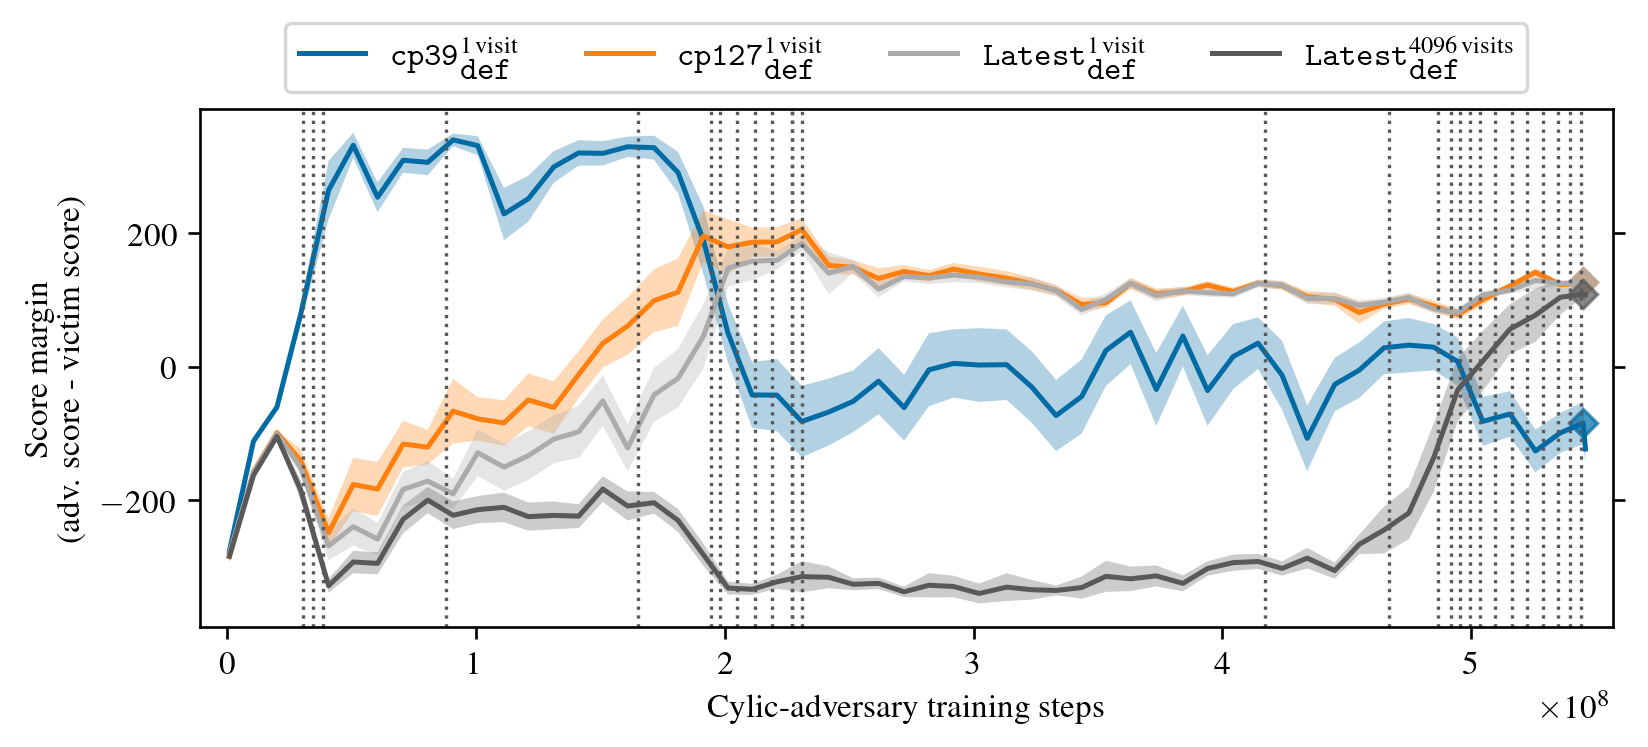

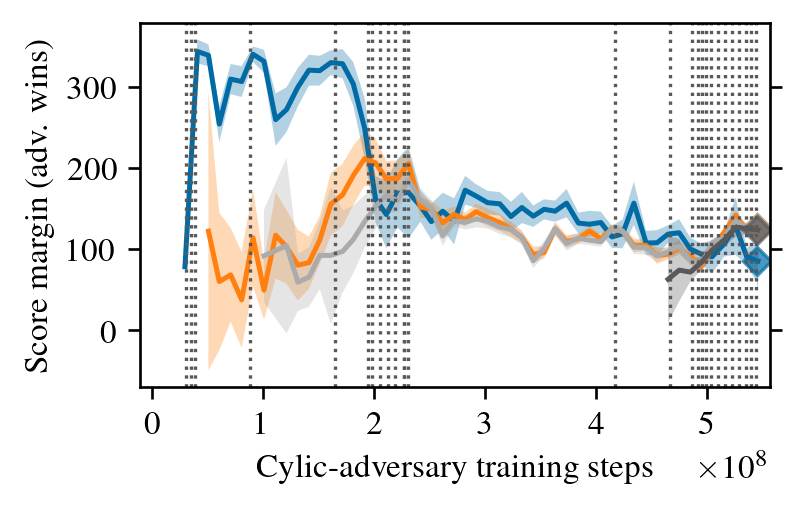

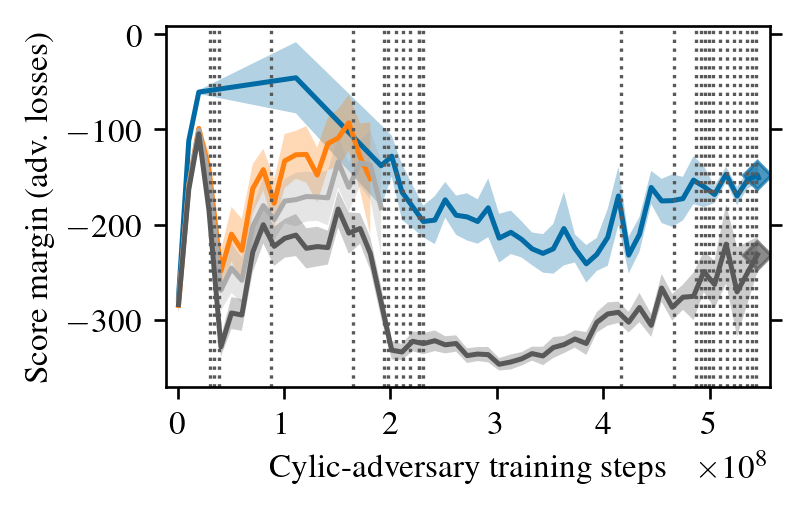

In [8]:
for intended_plot_type in ["scorediff", "scorediff_advwin", "scorediff_advlose"]:
    if intended_plot_type in ["scorediff_advwin", "scorediff_advlose"]:
        tmp_plot_style = utils.get_style("2-col")
    else:
        tmp_plot_style = utils.get_style("1-col")

    with plt.style.context(tmp_plot_style):
        fig, _ = plot_training(
            df,
            victim_name_to_plot_label,
            best_performance_mark,
            victim_change_steps,
            adv_name="Cylic",
            legend_ncol=4,
            wr_or_scorediff=intended_plot_type,
        )

    fig.savefig(f"adv-545mil-training-hardened-{intended_plot_type}.pgf", backend="pgf")